In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools

from sklearn import preprocessing
from sklearn import svm, metrics, neural_network, linear_model, ensemble
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


## VariableDefinition
survival: Survival 0 = No, 1 = Yes 

pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd 

Sex: 'male', 'female'

sibsp: # of siblings / spouses aboard the Titanic 

parch: # of parents / children aboard the Titanic

ticket: Ticket number

fare: Passenger fare 

cabin: Cabin number 

embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [4]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
data.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

# Exploratory data analysis

In [6]:
sns.set_style()

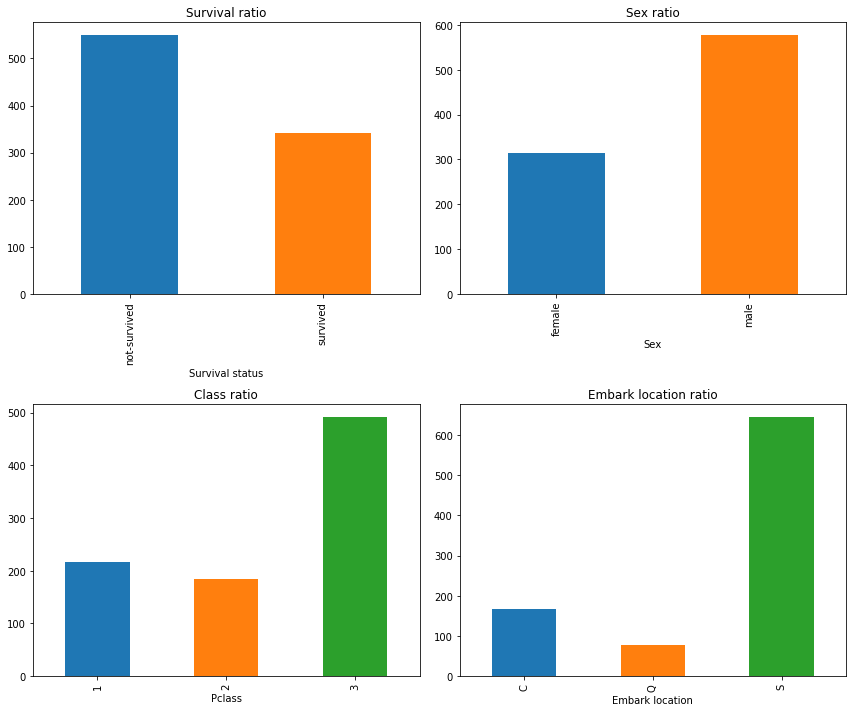

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_figheight(10)
fig.set_figwidth(12)

survive_group = data.groupby(('Survived'))[['Survived']].count()
survive_group.rename(columns={'Survived': 'count'}, inplace=True)

surv_ax = survive_group.unstack().plot.bar(ax=axes[0,0], title='Survival ratio')
surv_ax.set_xlabel('Survival status')
surv_ax.set_xticklabels(['not-survived', 'survived'])

gb_group = data.groupby(('Sex'))[['Sex']].count()
gb_group.rename(columns={'Sex': 'count'}, inplace=True)

sex_ax = gb_group.unstack().plot.bar(ax=axes[0,1], title='Sex ratio')
sex_ax.set_xlabel('Sex')
sex_ax.set_xticklabels(['female', 'male'])

class_group = data.groupby(('Pclass'))[['Pclass']].count()
class_group.columns = ['count']

class_ax = class_group.unstack().plot.bar(ax=axes[1,0], title='Class ratio')
class_ax.set_xlabel('Pclass')
class_ax.set_xticklabels(['1','2','3'])

embark_group = data.groupby(('Embarked'))[['Embarked']].count()
embark_group.columns = ['count']

embark_ax = embark_group.unstack().plot.bar(ax=axes[1,1], title='Embark location ratio')
embark_ax.set_xlabel('Embark location')
embark_ax.set_xticklabels(['C','Q','S'])

plt.tight_layout()
plt.show()

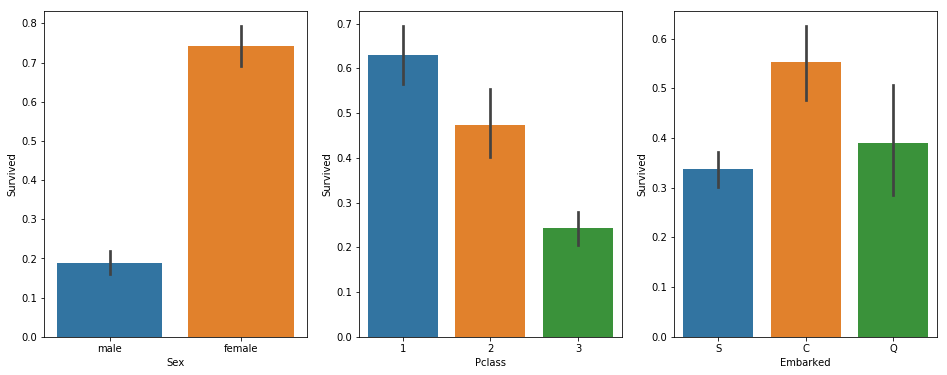

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 3)
fig.set_figheight(6)
fig.set_figwidth(16)

sns.barplot(x='Sex', y='Survived', data=data, ax=axes[0])

sns.barplot(x='Pclass', y='Survived', data=data, ax=axes[1])

sns.barplot(x='Embarked', y='Survived', data=data, ax=axes[2])

plt.show()

Sex perceivably is a strong indicator of survival rate compared to other variables.

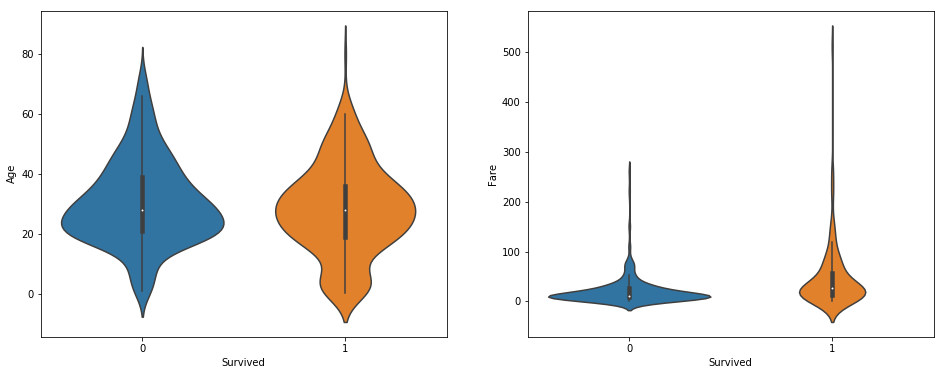

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

sns.violinplot(x='Survived', y='Age', data=data, ax=axes[0])

sns.violinplot(x='Survived', y='Fare', data=data, ax=axes[1])

plt.show()

From the left violinplot, there's a somewhat dense distribution of the survived population at the age lower than 18, which means that children (age < ~18) have a good chance to survive.

On the other hand, from the right violinplot, there's high density of the non-survived population around low ticket fares, which indicates high probability of not surviving when a person has a low ticket fare.

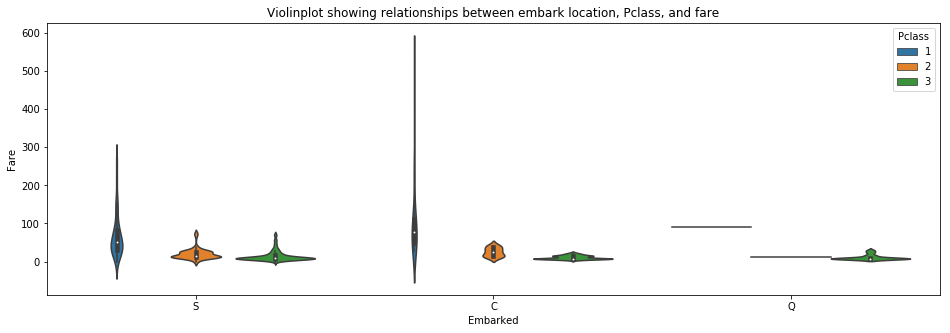

In [10]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(16)

sns.violinplot(x='Embarked', y='Fare', hue='Pclass', data=data)
plt.title('Violinplot showing relationships between embark location, Pclass, and fare')

plt.show()

Visualizing the relationships between the variables Pclass, embark location, and fare. And Pclass seems to strongly influence the value of fare. Therefore, we will fill the missing values of fare feature based on their Pclass values.

Another hypothesis that might help us determine the survival rate of each person is that big families may take longer to gather their family members. So, they have lower probability of surviving. As a result we will construct another feature called FamilySize computed by combining the sibling/spouse and parents/children columns together added by 1.

In [11]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

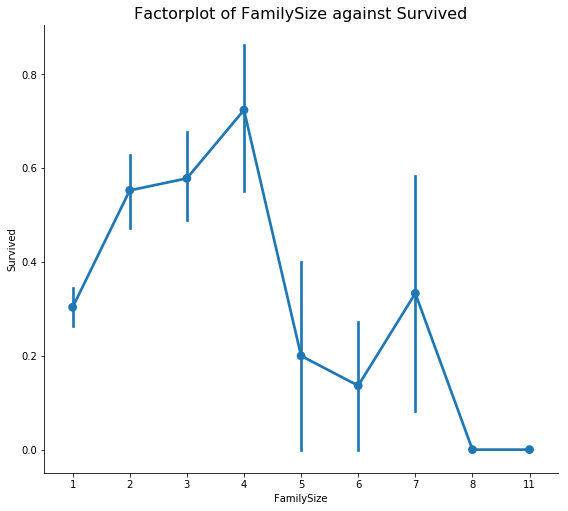

In [12]:
sns.factorplot(x = "FamilySize", y = "Survived", data = data, size = 8)
plt.title("Factorplot of FamilySize against Survived", fontsize = 16)
plt.subplots_adjust(top=0.85)
plt.show()

As we can see, people have higher probability of surviving when the family size is 2-4. We will categorize this range as a 'small' family size. The family size of 1 indicates that the person is alone. And we will categorize the family size that's bigger than 4 as a 'big' family.

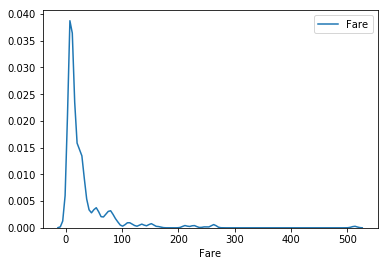

In [13]:
sns.kdeplot(data['Fare'])
plt.xlabel('Fare')
plt.show()

The distribution of ticket fare is left-skewed because of outliers. We will transform the data, so it's easier to visualize its relationships with other variables. And because the ticket fare variable shows the total fare of each group, we will divide its value with FamilySize feature to get the individual fare.

In [14]:
data['transformed_fare'] = np.log(data['Fare'].divide(data['FamilySize']))
data['transformed_fare'].replace([-np.inf], 0, inplace=True)

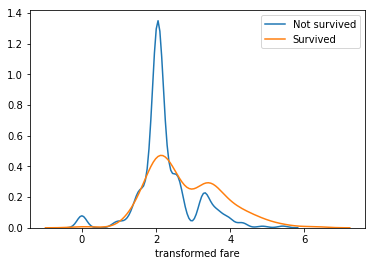

In [15]:
sns.kdeplot(data=data[data['Survived'] == 0]['transformed_fare'])
sns.kdeplot(data=data[data['Survived'] == 1]['transformed_fare'])
plt.xlabel('transformed fare')
plt.legend(['Not survived', 'Survived'])
plt.show()

The distribution of ticket fare after being transformed.

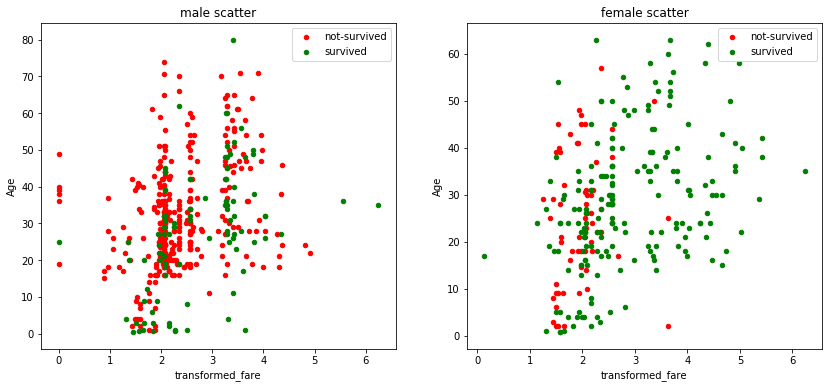

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(14)

data[np.logical_and(data['Sex'] == 'male', 
                    data['Survived'] == 0)].plot.scatter(x='transformed_fare', y='Age', color='red', title='male scatter',
                                                         label='not-survived', ax=axes[0])
data[np.logical_and(data['Sex'] == 'male', 
                    data['Survived'] == 1)].plot.scatter(x='transformed_fare', y='Age', color='green',
                                                         label='survived', ax=axes[0])

data[np.logical_and(data['Sex'] == 'female', 
                    data['Survived'] == 0)].plot.scatter(x='transformed_fare', y='Age', color='red', title='female scatter',
                                                         label='not-survived', ax=axes[1])
data[np.logical_and(data['Sex'] == 'female', 
                    data['Survived'] == 1)].plot.scatter(x='transformed_fare', y='Age', color='green',
                                                         label='survived', ax=axes[1])

plt.show()

While the male scatter plot shows a less clear relationship between ticket fare and survival rate, the female scatter plot demonstrates that people with higher ticket fare has a better chance of surviving.

          Survived    Pclass       Age      Fare     SibSp     Parch
Survived  1.000000 -0.338481 -0.077221  0.257307 -0.035322  0.081629
Pclass   -0.338481  1.000000 -0.369226 -0.549500  0.083081  0.018443
Age      -0.077221 -0.369226  1.000000  0.096067 -0.308247 -0.189119
Fare      0.257307 -0.549500  0.096067  1.000000  0.159651  0.216225
SibSp    -0.035322  0.083081 -0.308247  0.159651  1.000000  0.414838
Parch     0.081629  0.018443 -0.189119  0.216225  0.414838  1.000000


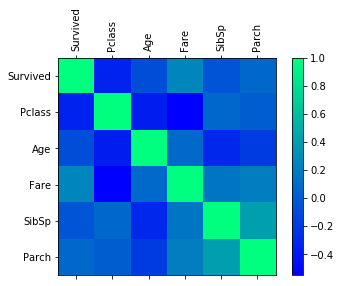

In [17]:
corr_labels = ['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']
corrs = data.loc[:,corr_labels].corr()
print(corrs)

fig = plt.figure()
ax = fig.add_subplot(111)

cax = ax.matshow(corrs, cmap='winter')
fig.colorbar(cax)
ticks = np.arange(0,6,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_labels, rotation=90)
ax.set_yticklabels(corr_labels)
plt.show()

Age variable shows a certain level of correlation with Pclass, SibSp, and Parch variables. Therefore, we'll use these variables as features to train a regressor model to fill the missing values in the age column.

Next we will explore the feature Cabin that indicates the cabin number of a passenger. There are many missing values in this column. So, we will fill the missing value with 'N' and extract the first character of each cabin number that indicate the cabin sector. Then we will categorize data into 2 groups consisting of ones that have cabins (have cabin numbers) and the ones that don't (cabin numbers are null) and label the feature as 'HasCabin.'

In [18]:
data['Cabin'].fillna(value='N', inplace=True)
data['Cabin'] = data['Cabin'].str[0]

In [19]:
cabsur_group = data.groupby(('Survived', 'Cabin'))[['Cabin']].count()
#cabin_map = {cabin: i for i, cabin in enumerate(data['Cabin'].value_counts().keys())}
#print(cabin_map)

In [20]:
data['HasCabin'] = data['Cabin'].map(lambda x: 'Y' if x != 'N' else 'N')

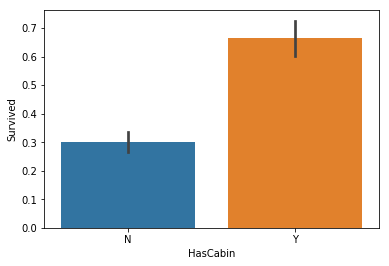

In [21]:
sns.barplot(x='HasCabin', y='Survived', data=data)

plt.show()

It seems that HasCabin feature could help inform us the survival rate of a passenger. Thus, we will feed this feature into our machine learning model as well.

## Feature engineering training

In [22]:
def categorize_family(fam_size):
    category = ''
    if fam_size == 1:
        category = 'alone'
    elif fam_size <= 4:
        category = 'small'
    else:
        category = 'big'
    return category

def categorize_fare(log_fare):
    category = ''
    if log_fare <= 1.5:
        category = 'low'
    elif log_fare <= 3:
        category = 'average'
    elif log_fare <= 4:
        category = 'high'
    else:
        category = 'very high'
    return category

In [23]:
train_target = data['Survived']

data['FamilyType'] = data['FamilySize'].map(categorize_family)
data['FareRange'] = data['transformed_fare'].map(categorize_fare)

In [24]:
fare_medians = data.groupby(('Pclass'))['Fare'].median()
print(fare_medians)

Pclass
1    60.2875
2    14.2500
3     8.0500
Name: Fare, dtype: float64


### Train a regression model to fill missing age values

In [25]:
# data splitting
age_features = data[np.logical_not(data['Age'].isnull())][['Age', 'Pclass', 'transformed_fare', 'SibSp', 'Parch']]
age_labels = age_features[['Age']]
age_features = age_features.iloc[:,1:]

x_age_train, x_age_test, y_age_train, y_age_test = train_test_split(age_features, age_labels, test_size=0.2,
                                                                    random_state=1)

print(y_age_train.head())
print(x_age_train.head())

      Age
830  15.0
565  24.0
148  36.5
105  28.0
289  22.0
     Pclass  transformed_fare  SibSp  Parch
830       3          1.977838      1      0
565       3          2.085672      2      0
148       2          2.159484      0      2
105       3          2.066331      0      0
289       3          2.047693      0      0


In [26]:
# Initializing a gradient boosting model with GridSearchCV to tune the hyperparameters
param_grid = {'max_depth': np.arange(2,5), 'n_estimators': np.arange(10, 101, 10)}
age_regressor = ensemble.RandomForestRegressor(verbose=False)
age_gm = GridSearchCV(age_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')
age_gm.fit(x_age_train, np.array(y_age_train).ravel())

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=False,
           warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([2, 3, 4]), 'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [27]:
print(age_gm.best_params_)
print(age_gm.best_score_)

{'max_depth': 4, 'n_estimators': 10}
-152.233115165579


In [28]:
y_age_pred = age_gm.predict(x_age_test)
print(metrics.r2_score(y_age_test, y_age_pred))
print(metrics.mean_squared_error(y_age_test, y_age_pred))

0.26012143090095363
153.97079458804797


In [29]:
def fill_value_by_ml(row, target_col, feature_cols, model):
    features = row[feature_cols]
    if np.isnan(row[target_col]):
        return float(model.predict([features]))
    else:
        return row[target_col]

def categorize_age(age):
    category = ''
    if age <= 1:
        category = 'infant'
    elif age <= 4:
        category = 'toddler'
    elif age <= 13:
        category = 'child'
    elif age <= 18:
        category = 'teenager'
    elif age <= 35:
        category = 'young adult'
    elif age <= 45:
        category = 'adult'
    elif age <= 55:
        category = 'middle aged'
    elif age <= 65:
        category = 'senior citizen'
    else:
        category = 'old'
    return category

In [30]:
print(age_gm.predict([data.loc[0, ['Pclass', 'transformed_fare', 'SibSp', 'Parch']]]))
print(data.loc[0, 'Age'])

[26.36231537]
22.0


In [31]:
data['Age'] = data.apply(fill_value_by_ml, axis=1, target_col='Age',
                         feature_cols=['Pclass', 'transformed_fare', 'SibSp', 'Parch'], model=age_gm)

In [32]:
data['AgeClass'] = data['Age'].map(categorize_age)

In [33]:
cat_labels = ['Sex', 'Embarked', 'FamilyType', 'HasCabin', 'Pclass', 'AgeClass', 'FareRange']
train_data = pd.get_dummies(data, columns=cat_labels)

drop_labels = ['Survived', 'Name', 'SibSp', 'Parch', 'Cabin', 'Age', 'FamilySize', 'Fare', 'transformed_fare']
train_data.drop(columns=drop_labels, inplace=True)

## Training models

In [34]:
k_fold = 4
test_size = 1/k_fold

## Neural networks

In [35]:
# Experimental parameters
layer_nums = np.arange(2,4)
unit_nums = np.arange(3,11)
param_grid = {'hidden_layer_sizes': list(itertools.product(layer_nums, unit_nums))}

In [36]:
ann = neural_network.MLPClassifier(max_iter=500)

ann_gm = GridSearchCV(ann, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
ann_gm.fit(train_data, train_target)

GridSearchCV(cv=4, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [37]:
print(ann_gm.best_params_)
print(ann_gm.best_score_)

{'hidden_layer_sizes': (2, 3)}
0.813692480359147


## Random Forest

In [38]:
# Experimental parameters
depths = np.arange(5,15)
n_estimators = np.arange(10, 271, 30)

param_grid = dict(max_depth=depths, n_estimators=n_estimators)

In [39]:
rand_forest = ensemble.RandomForestClassifier()

forest_gm = GridSearchCV(rand_forest, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
forest_gm.fit(train_data, train_target)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'n_estimators': array([ 10,  40,  70, 100, 130, 160, 190, 220, 250])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [40]:
print(forest_gm.best_params_)
print(forest_gm.best_score_)

{'max_depth': 10, 'n_estimators': 10}
0.8058361391694725


## XGBoost

In [41]:
# Experimental parameters
depths = np.arange(3,8)
n_estimators = np.arange(150, 401, 50)

param_grid = dict(max_depth=depths, n_estimators=n_estimators)

In [42]:
xboost = xgb.XGBClassifier()

xgb_gm = GridSearchCV(xboost, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1, verbose=False)
xgb_gm.fit(train_data, train_target, verbose=False)

GridSearchCV(cv=4, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7]), 'n_estimators': array([150, 200, 250, 300, 350, 400])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=False)

In [43]:
print(xgb_gm.best_params_)
print(xgb_gm.best_score_)

{'max_depth': 4, 'n_estimators': 200}
0.8159371492704826


# Test

In [44]:
test_df = pd.read_csv('test.csv')

In [46]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [47]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['FamilyType'] = test_df['FamilySize'].map(categorize_family)

test_df['Fare'] = test_df.apply(lambda x: x.loc['Fare'] if not np.isnan(x.loc['Fare']) else fare_medians[x.loc['Pclass']],
                                axis=1)
test_df['transformed_fare'] = np.log(test_df['Fare'].divide(test_df['FamilySize']))
test_df['transformed_fare'].replace([-np.inf], 0, inplace=True)
test_df['FareRange'] = test_df['transformed_fare'].map(categorize_fare)

test_df['Cabin'].fillna(value='N', inplace=True)
test_df['Cabin'] = test_df['Cabin'].str[0]
test_df['HasCabin'] = test_df['Cabin'].apply(lambda x: 'Y' if x != 'N' else 'N')

test_df['Age'] = test_df.apply(fill_value_by_ml, axis=1, target_col='Age',
                               feature_cols=['Pclass', 'transformed_fare', 'SibSp', 'Parch'], model=age_gm)
test_df['AgeClass'] = test_df['Age'].map(categorize_age)

In [48]:
test_data = pd.get_dummies(test_df, columns=cat_labels)
test_data.drop(columns=['PassengerId', 'Ticket'], inplace=True)
test_data.drop(columns=drop_labels[1:], inplace=True)

In [49]:
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 26 columns):
Sex_female                 418 non-null uint8
Sex_male                   418 non-null uint8
Embarked_C                 418 non-null uint8
Embarked_Q                 418 non-null uint8
Embarked_S                 418 non-null uint8
FamilyType_alone           418 non-null uint8
FamilyType_big             418 non-null uint8
FamilyType_small           418 non-null uint8
HasCabin_N                 418 non-null uint8
HasCabin_Y                 418 non-null uint8
Pclass_1                   418 non-null uint8
Pclass_2                   418 non-null uint8
Pclass_3                   418 non-null uint8
AgeClass_adult             418 non-null uint8
AgeClass_child             418 non-null uint8
AgeClass_infant            418 non-null uint8
AgeClass_middle aged       418 non-null uint8
AgeClass_old               418 non-null uint8
AgeClass_senior citizen    418 non-null uint8
AgeClass_teenager    

## Neural networks

In [50]:
test_pred = ann_gm.predict(test_data)

submission score = 0.77511

## Random Forest

In [52]:
test_pred = forest_gm.predict(test_data)

submission score = 0.74162

## XGBoost

In [54]:
test_pred = xgb_gm.predict(test_data)

submission score = 0.77033

## Saving predictions

In [55]:
output_df = pd.DataFrame(test_df['PassengerId'])
output_df['Survived'] = test_pred
output_df.to_csv('titanic_submission.csv', index=False)